<div style="background-color:white; text-align:center; font-family:Arial, Helvetica, sans-serif; padding:50px;">
  <!-- Tytuł -->
  <div style="color:#993520; font-size:60px; font-weight:bold; margin-bottom:20px;">
    SENTIMENT ANALYSIS - PROJECT
  </div>

  <!-- Podtytuł -->
  <div style="color:#993520; font-size:35px; margin-bottom:40px;">
    Donald Trump Tweets Analysis
  </div>

  <!-- Autor -->
  <div style="color:black; font-size:30px; margin-bottom:10px;">
    Weronika Mądro & Wojciech Hrycenko
  </div>

  <!-- Data / semestr -->
  <div style="color:black; font-size:30px; margin-bottom:20px;">
    Autumn 2025
  </div>

### 1. Introduction and Project Goal

The objective of this notebook is to perform Sentiment Analysis on the `realdonaldtrump.csv` dataset. This dataset contains tweets published by Donald Trump as of June 2020. Link to the dataset: [realdonaldtrump.csv](https://www.kaggle.com/datasets/austinreese/trump-tweets).

The project aims to investigate and compare two different approaches to text sentiment analysis, as per the requirements:
1.  Application of at least one dictionary-based method.
2.  Application of at least one supervised learning method.
3.  Hyperparameter optimization for the supervised model.

### 2. Project Plan (Methodology)

This notebook is divided into logical stages that guide us through the entire analysis process:

* **Stage 1: Data Loading & Preprocessing:** We will load the data and clean the `content` column by removing URLs, mentions (@), hashtags (#), and other characters that could interfere with the analysis.

* **Stage 2: Exploratory Data Analysis (EDA):** We will examine the cleaned data, for instance, by analyzing the most frequent words, to better understand the characteristics of the dataset.

* **Stage 3: Dictionary-Based Method (VADER):** We will apply **VADER** (`SentimentIntensityAnalyzer`) as our dictionary-based method. It is particularly well-suited for social media texts. We will generate a `compound` score (from -1 to +1) for each tweet.

* **Stage 4: Preparation for Supervised Model:** The `vader_compound` score from Stage 3 will serve as our continuous target variable (`y`). This turns our task into a **regression problem**: the model will learn to predict the sentiment score based on the text. We will then transform the `cleaned_content` into **n-grams** and a numerical feature matrix (`X`) using a **CountVectorizer** or **TF-IDF**.

* **Stage 5 & 6: Supervised Model & Optimization:** We will train a **regression model** (e.g., **LASSO Regression**, **SVR**, or **RandomForestRegressor**, as seen in the class notebooks). We will then use **GridSearchCV** to find the optimal hyperparameters for this model.

* **Stage 7 & 8: Evaluation and Results Comparison:** We will evaluate the performance of our optimized model using a regression metric, primarily **RMSE** (Root Mean Squared Error). Finally, we will present a concise comparison of the results.

*1. Data Loading and Preprocessing*

In [ ]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from IPython.display import display
# nltk.download('punkt_tab')
# nltk.download('vader_lexicon')
# nltk.download('punkt') # For tokenization (splitting into words)
# nltk.download('stopwords') # List of common words (stop-words)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\wojci\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [14]:
import pandas as pd
import re
from IPython.display import display

# 1. Definition of the function to clean text
def clean_tweet(text):
    """
    Function to clean a single tweet.
    """
    # Ensure we are working with a string and change to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove mentions (e.g., @user)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (e.g., #example) - we only leave the word
    text = re.sub(r'#', '', text)
    
    # Remove punctuation, numbers, and other special characters
    # We only leave letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove excess whitespace (e.g., double spaces)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# 2. Loading data from the CSV file
# Make sure the 'realdonaldtrump.csv' file is in the same folder
try:
    df = pd.read_csv("realdonaldtrump.csv")
    
    # 3. Applying the cleaning function to the 'content' column
    # We create a new column 'cleaned_content' to keep the original
    df['cleaned_content'] = df['content'].apply(clean_tweet)

    # 4. Displaying the results
    print("--- Data loaded successfully ---")
    print(f"Number of rows (tweets) in the file: {len(df)}")
    
    print("\n--- Comparison (first 5 rows) ---")
    
    # Zamiast print(), używamy display() dla ładnego formatowania HTML
    display(df[['content', 'cleaned_content']].head())
    
    df.head()

except FileNotFoundError:
    print("ERROR: File 'realdonaldtrump.csv' not found.")
    print("Make sure the file is in the same folder as the script.")

--- Data loaded successfully ---
Number of rows (tweets) in the file: 43352

--- Comparison (first 5 rows) ---


,content,cleaned_content
0,Be sure to tune in and watch Donald Trump on L...,be sure to tune in and watch donald trump on l...
1,Donald Trump will be appearing on The View tom...,donald trump will be appearing on the view tom...
2,Donald Trump reads Top Ten Financial Tips on L...,donald trump reads top ten financial tips on l...
3,New Blog Post: Celebrity Apprentice Finale and...,new blog post celebrity apprentice finale and ...
4,"""My persona will never be that of a wallflower...",my persona will never be that of a wallflower ...


*2. Exploratory Data Analysis (EDA)*


--- Starting Stage 2: Exploratory Data Analysis (EDA) ---

--- 20 Most Common Words ---


,Word,Frequency
0,realdonaldtrump,8576
1,great,6633
2,trump,6017
3,thank,3028
4,president,2899
5,people,2670
6,thanks,2167
7,would,1993
8,get,1958
9,new,1953



Generating plot...


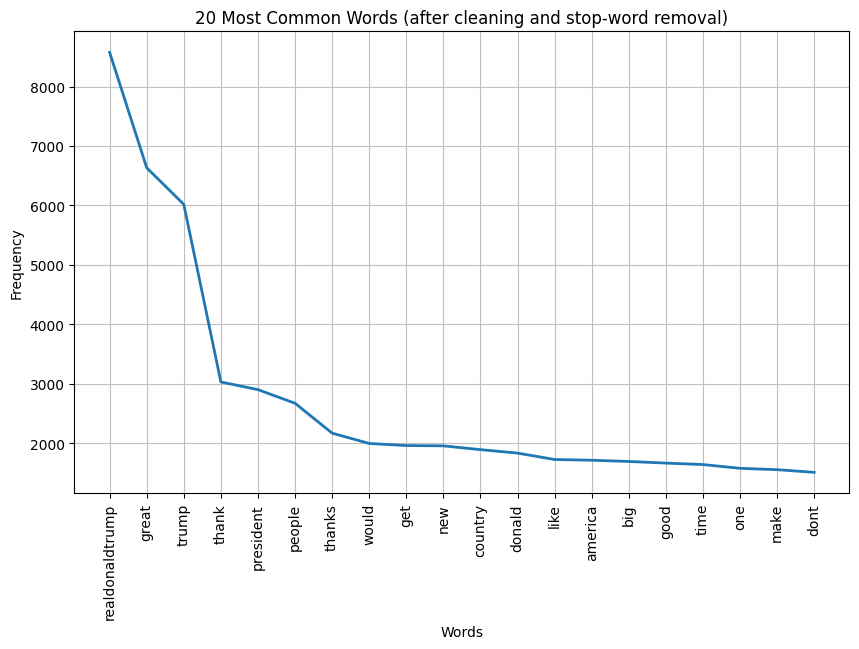

--- Stage 2 Complete ---


In [ ]:
# Make sure the DataFrame 'df' exists from Stage 1
if 'df' in locals():
    
    # 1. Prepare text for frequency analysis
    # We join all cleaned tweets into one long text
    all_tweets = " ".join(df['cleaned_content'].dropna())
    
    # 2. Tokenization (splitting text into individual words)
    tokens = word_tokenize(all_tweets)
    
    # 3. Remove "stop-words" (common words, e.g., 'the', 'is', 'in')
    # We use the English stop-words list from NLTK
    stop_words = set(stopwords.words('english'))
    
    # We create a list of words that ARE NOT stop-words and have more than 2 letters
    filtered_tokens = [
        word for word in tokens 
        if word.lower() not in stop_words and len(word) > 2
    ]
    
    # 4. Calculate word frequencies
    # FreqDist is a special NLTK tool for counting words
    freq_dist = nltk.FreqDist(filtered_tokens)
    
    # 5. Display the 20 most common words (as a formatted table)
    print("\n--- 20 Most Common Words ---")
    common_words_df = pd.DataFrame(freq_dist.most_common(20), 
                                   columns=['Word', 'Frequency'])
    display(common_words_df)
    
    # 6. Visualization (Bar chart of the 20 most common words)
    plt.figure(figsize=(10, 6))
    freq_dist.plot(20, title="20 Most Common Words (after cleaning and stop-word removal)")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.show()

else:
    print("ERROR: 'df' object does not exist. Run Stage 1 first.")

*3. Method 1: Dictionary-Based (Lexicon) Sentiment Analysis*

In [18]:
# VADER (Valence Aware Dictionary and sEntiment Reasoner) is a popular sentiment analysis tool that can work both at the level of single words and whole sentences;
# it aims at higher effectiveness in analysing specifically social media content as it introduces plenty of minor specificities into its dictionary such as abbreviations, 
# slang, emoticons. Also, it appears to work better with shorter texts; it returns negative, neutral, and positive (each component can take values from 0 to 1, yet all sum up to 1) 
# sentiment scores, along with the overall score of a text (compound, takes values from -1 to +1)

text = "From Donald Trump: Wishing everyone a wonderful holiday & a happy, healthy, prosperous New Year. Let’s think like champions in 2010"

sia = SentimentIntensityAnalyzer()
sentiment_scores = sia.polarity_scores(text)
sentiment_scores

{'neg': 0.0, 'neu': 0.297, 'pos': 0.703, 'compound': 0.9709}

In [19]:
# the below demonstrates that VADER is not based on (only) summing up per word (or token) scores and scalling them; in fact, VADER modifies predefined sentiment values
# for words and expressions by analysing their context (e.g. intensifiers, negation, punctuation, capital letters). The whole thing is much more developed than with, 
# for example, TextBlob

for token in text.split(' '):
    sentiment = sia.polarity_scores(token); print(token,'-','negative:',sentiment['neg'],'neutral:',sentiment['neu'],'positive:',sentiment['pos'],'compound:',sentiment['compound'])

From - negative: 0.0 neutral: 1.0 positive: 0.0 compound: 0.0
Donald - negative: 0.0 neutral: 1.0 positive: 0.0 compound: 0.0
Trump: - negative: 0.0 neutral: 1.0 positive: 0.0 compound: 0.0
Wishing - negative: 0.0 neutral: 0.0 positive: 1.0 compound: 0.2263
everyone - negative: 0.0 neutral: 1.0 positive: 0.0 compound: 0.0
a - negative: 0.0 neutral: 0.0 positive: 0.0 compound: 0.0
wonderful - negative: 0.0 neutral: 0.0 positive: 1.0 compound: 0.5719
holiday - negative: 0.0 neutral: 0.0 positive: 1.0 compound: 0.4019
& - negative: 0.0 neutral: 0.0 positive: 0.0 compound: 0.0
a - negative: 0.0 neutral: 0.0 positive: 0.0 compound: 0.0
happy, - negative: 0.0 neutral: 0.0 positive: 1.0 compound: 0.5719
healthy, - negative: 0.0 neutral: 0.0 positive: 1.0 compound: 0.4019
prosperous - negative: 0.0 neutral: 0.0 positive: 1.0 compound: 0.4767
New - negative: 0.0 neutral: 1.0 positive: 0.0 compound: 0.0
Year. - negative: 0.0 neutral: 1.0 positive: 0.0 compound: 0.0
Let’s - negative: 0.0 neutral:

Applied VADER analysis to the 'cleaned_content' column.

--- Comparison (first 10 rows) ---


,cleaned_content,vader_neg,vader_neu,vader_pos,vader_compound
0,be sure to tune in and watch donald trump on l...,0.000,0.837,0.163,0.4767
1,donald trump will be appearing on the view tom...,0.000,0.748,0.252,0.7506
2,donald trump reads top ten financial tips on l...,0.000,0.723,0.277,0.6115
3,new blog post celebrity apprentice finale and ...,0.000,1.000,0.000,0.0000
4,my persona will never be that of a wallflower ...,0.000,1.000,0.000,0.0000
5,miss usa tara conner will not be fired ive alw...,0.075,0.703,0.222,0.4809
6,listen to an interview with donald trump discu...,0.000,0.652,0.348,0.7506
7,strive for wholeness and keep your sense of wo...,0.000,0.859,0.141,0.2023
8,enter the think like a champion signed book an...,0.000,0.556,0.444,0.7506
9,when the achiever achieves its not a plateau i...,0.000,1.000,0.000,0.0000



--- Statistical Summary of VADER scores ---


,vader_neg,vader_neu,vader_pos,vader_compound
count,43352.000000,43352.000000,43352.000000,43352.000000
mean,0.075076,0.725054,0.197701,0.212220
std,0.115039,0.192211,0.196212,0.521555
min,0.000000,0.000000,0.000000,-0.986600
25%,0.000000,0.614000,0.000000,-0.051600
50%,0.000000,0.734000,0.161000,0.318200
75%,0.133000,0.854000,0.307250,0.648600
max,1.000000,1.000000,1.000000,0.989500



--- Histogram of VADER Compound Scores ---


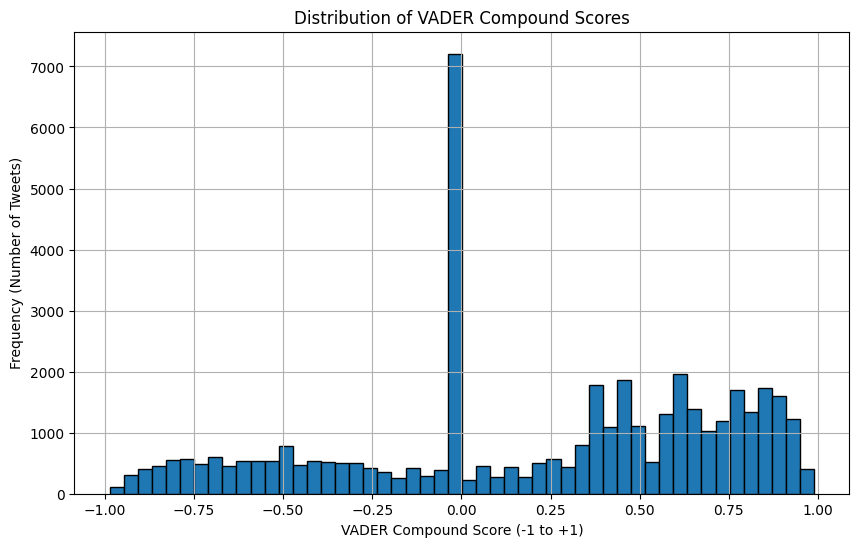


--- 3 Most Negative Tweets ---


,content,vader_compound
43212,Colin Powell was a pathetic interview today on...,-0.9866
35086,It is outrageous that Poisonous Synthetic Hero...,-0.9837
36466,The Trump portrait of an unsustainable Border ...,-0.9825



--- 3 Most Positive Tweets ---


,content,vader_compound
33905,Congratulations to Patrick Reed on his great a...,0.9895
43165,I am a big fan of Drew Brees. I think he’s tru...,0.9868
17015,"Good luck and best wishes to my dear friend, t...",0.9854


In [ ]:
# Make sure the DataFrame 'df' exists from Stage 1
if 'df' in locals():

    # Remove previous VADER columns if they already exist
    vader_cols = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']
    df = df.drop(columns=[c for c in vader_cols if c in df.columns], errors='ignore')

    # 1. Initialize the VADER analyzer
    sia = SentimentIntensityAnalyzer()

    # 2. Apply VADER and expand results
    vader_results = df['cleaned_content'].apply(lambda text: pd.Series(sia.polarity_scores(text)))
    vader_results = vader_results.rename(columns={
        'neg': 'vader_neg',
        'neu': 'vader_neu',
        'pos': 'vader_pos',
        'compound': 'vader_compound'
    })

    # 3. Concatenate the new columns back to the main DataFrame
    df = pd.concat([df, vader_results], axis=1)
    
    print("Applied VADER analysis to the 'cleaned_content' column.")

    # 4. Display the results (head)
    print("\n--- Comparison (first 10 rows) ---")
    columns_to_show = ['cleaned_content', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']
    display(df[columns_to_show].head(10))
    
    # 5. Statistical Summary
    print("\n--- Statistical Summary of VADER scores ---")
    display(df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']].describe())

    # 6. Histogram
    print("\n--- Histogram of VADER Compound Scores ---")
    plt.figure(figsize=(10, 6))
    df['vader_compound'].hist(bins=50, edgecolor='black')
    plt.title('Distribution of VADER Compound Scores')
    plt.xlabel('VADER Compound Score (-1 to +1)')
    plt.ylabel('Frequency (Number of Tweets)')
    plt.show()
    
    # 7. Most negative tweets
    print("\n--- 3 Most Negative Tweets ---")
    worst_opinions = df.sort_values(by="vader_compound").head(3)[['content', 'vader_compound']]
    display(worst_opinions)

    # 8. Most positive tweets
    print("\n--- 3 Most Positive Tweets ---")
    best_opinions = df.sort_values(by="vader_compound", ascending=False).head(3)[['content', 'vader_compound']]
    display(best_opinions)

else:
    print("ERROR: 'df' object does not exist. Run Stage 1 first.")

*4. Data Preparation for Supervised Learning*

*6. Hyperparameter Optimization*

*5. Method 2: Supervised Model Training*

   *7. Model Evaluation and Results Comparison*

*8. Final Results Presentation*